# Client quote status prediction

## EDA

In [9]:
%matplotlib inline

import pandas as pd
from ydata_profiling import ProfileReport
from ydata_profiling.visualisation.plot import correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
import seaborn as sns
from matplotlib import pyplot as plt
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import pandas as pd
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_predict
import multiprocessing
from helpers import start_mlflow_server
import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

import warnings

warnings.filterwarnings("ignore")

In [10]:
df = pd.read_csv("../resources/quotes.csv")

# profile = ProfileReport(df, title='Quotes Dataset')

# profile.to_notebook_iframe()

### Initial data analysis

The dataset is clean, no missing values or duplicate rows.

Our task is a binary classification task where we want to predict whether client will accept the quote or not, hence the target variable is `QUOTE_STATUS`.
We can transform our target into binary variable `QUOTE_ACCEPTED` right away. This is an imbalanced class what we'll have to account for later.

In [11]:
df.rename(columns={"TOTAL_REMIUM": "TOTAL_PREMIUM"}, inplace=True)
df["QUOTE_ACCEPTED"] = df["QUOTE_STATUS"].apply(lambda x: 1 if x == "Accepted" else 0)

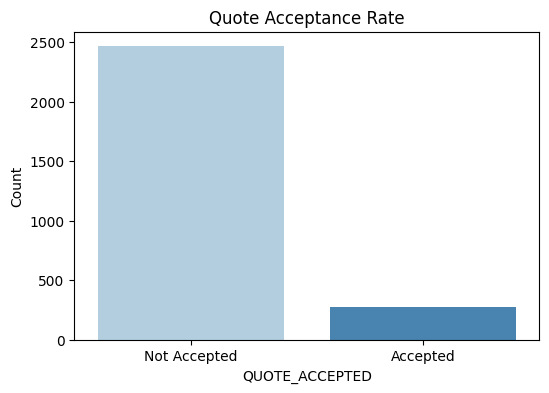

In [12]:
plt.figure(figsize=(6, 4))
sns.barplot(x=df["QUOTE_ACCEPTED"].value_counts().index, y=df["QUOTE_ACCEPTED"].value_counts().values, palette="Blues")
plt.xticks([0, 1], ["Not Accepted", "Accepted"])
plt.ylabel("Count")
plt.title("Quote Acceptance Rate")
plt.show()

As `CLIENT_ID` feature is directly related to our target yet has no predictive power, we want to eliminate it right away so that our model predictions are not clouded by it.<br>
Also, we can get rid of `VEHICLE` feature, as we already have data related to vehicle in other numerical features and information in that field might not bring any value while requiring complicated processing.

In [13]:
df = df[df.columns.difference(["CLIENT_ID", "VEHICLE"])]

We can break down `CREATED_AT` datetime feature into multiple features.

In [14]:
def engineer_date_features(df, date_column):
    df[f"{date_column}_year"] = df[date_column].dt.year
    df[f"{date_column}_month"] = df[date_column].dt.month.astype(int)
    df[f"{date_column}_weekday"] = df[date_column].dt.weekday.astype(int)
    df[f"{date_column}_quarter"] = df[date_column].dt.quarter.astype(int)
    df[f"{date_column}_hour"] = df[date_column].dt.hour.astype(int)
    df[f"{date_column}_minute"] = df[date_column].dt.minute.astype(int)
    df[f"{date_column}_is_weekend"] = (df[date_column].dt.weekday >= 5).astype(int)
    return df


df["CREATED_AT"] = pd.to_datetime(df["CREATED_AT"])
df = engineer_date_features(df, "CREATED_AT")

### Insights

#### Time-related

First let's analyze time-related patterns in quote acceptance.

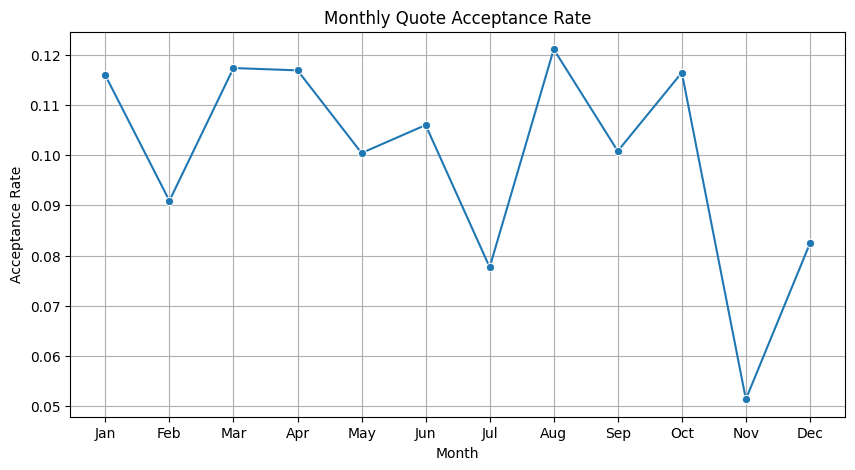

In [15]:
monthly_acceptance = df.groupby("CREATED_AT_month")["QUOTE_ACCEPTED"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_acceptance.index, y=monthly_acceptance.values, marker="o", linestyle="-")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Acceptance Rate")
plt.title("Monthly Quote Acceptance Rate")
plt.grid(True)
plt.show()

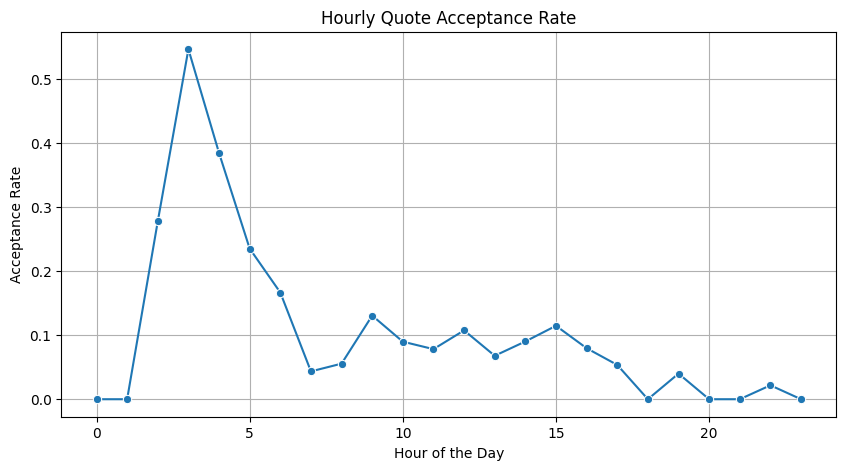

In [16]:
hourly_acceptance = df.groupby("CREATED_AT_hour")["QUOTE_ACCEPTED"].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_acceptance.index, y=hourly_acceptance.values, marker="o", linestyle="-")
plt.xlabel("Hour of the Day")
plt.ylabel("Acceptance Rate")
plt.title("Hourly Quote Acceptance Rate")
plt.grid(True)
plt.show()

#### Broker-related


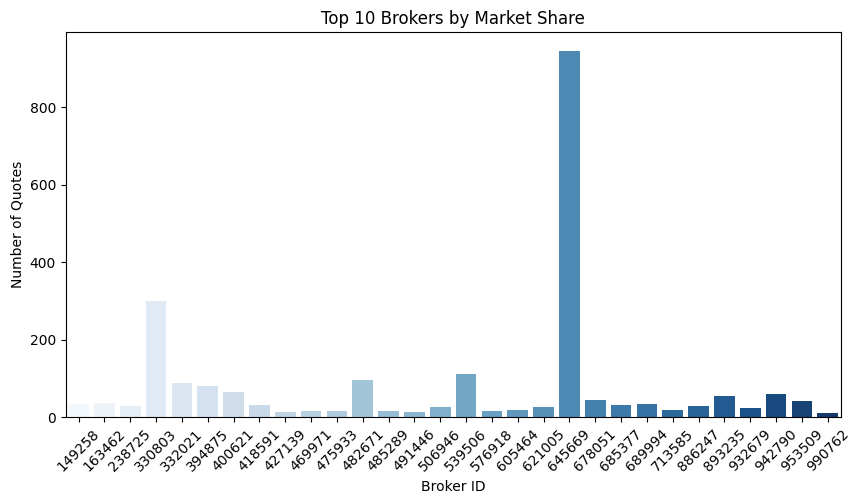

In [17]:
top_brokers = df["BROKER_ID"].value_counts().head(30)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_brokers.index, y=top_brokers.values, palette="Blues")
plt.xticks(rotation=45)
plt.xlabel("Broker ID")
plt.ylabel("Number of Quotes")
plt.title("Top 10 Brokers by Market Share")
plt.show()

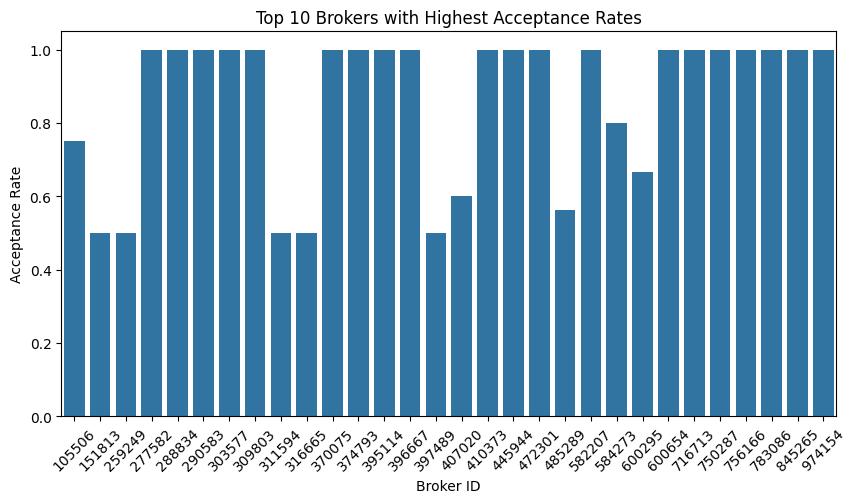

In [18]:
broker_acceptance = df.groupby("BROKER_ID")["QUOTE_ACCEPTED"].mean().nlargest(30)
plt.figure(figsize=(10, 5))
sns.barplot(x=broker_acceptance.index, y=broker_acceptance.values)
plt.xticks(rotation=45)
plt.xlabel("Broker ID")
plt.ylabel("Acceptance Rate")
plt.title("Top 10 Brokers with Highest Acceptance Rates")
plt.show()

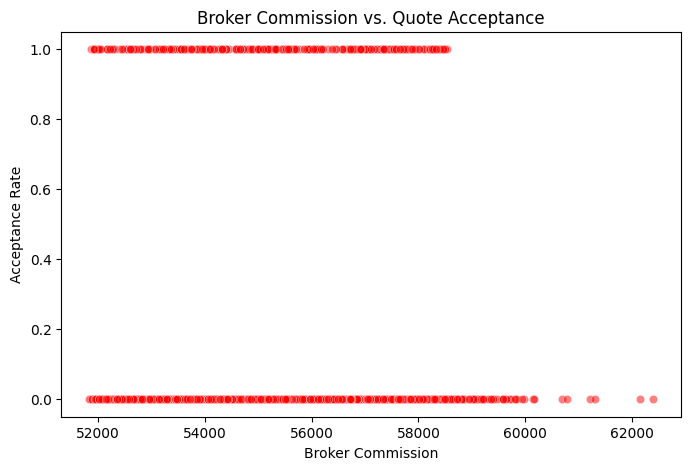

In [19]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["BROKER_COMMISSION"], y=df["QUOTE_ACCEPTED"], alpha=0.5, color="red")
plt.xlabel("Broker Commission")
plt.ylabel("Acceptance Rate")
plt.title("Broker Commission vs. Quote Acceptance")
plt.show()

#### Pricing factors

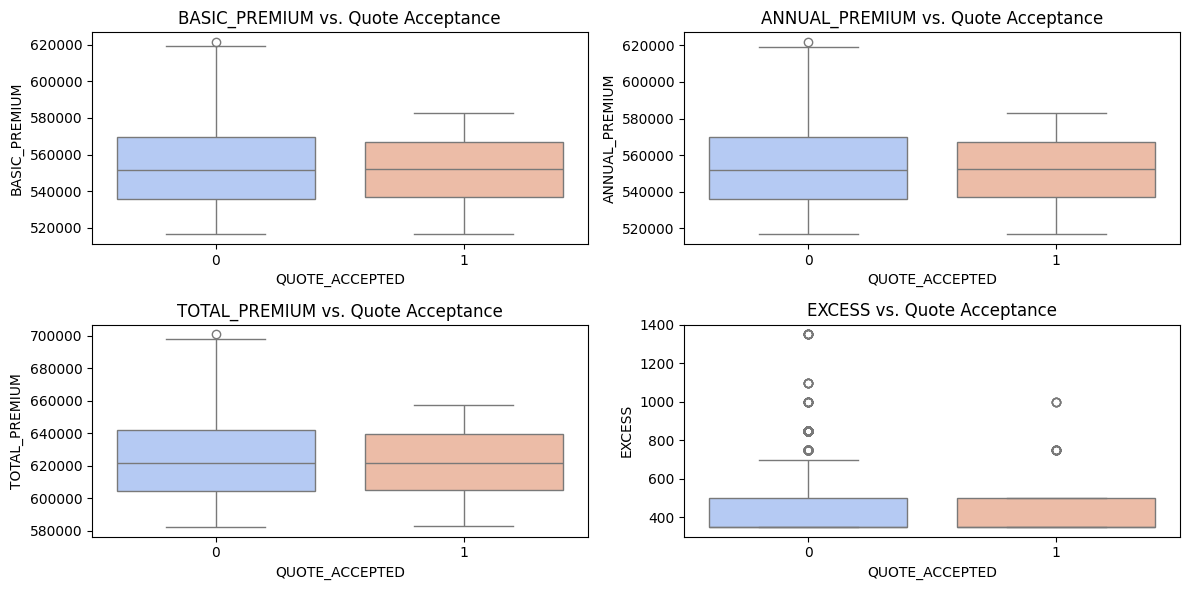

In [20]:
plt.figure(figsize=(12, 6))

pricing_features = ["BASIC_PREMIUM", "ANNUAL_PREMIUM", "TOTAL_PREMIUM", "EXCESS"]

for i, feature in enumerate(pricing_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df["QUOTE_ACCEPTED"], y=df[feature], palette="coolwarm")
    plt.title(f"{feature} vs. Quote Acceptance")

plt.tight_layout()
plt.show()

Do higher/lower premiums lead to better acceptance rates?
Are accepted quotes less likely to have high EXCESS fees?

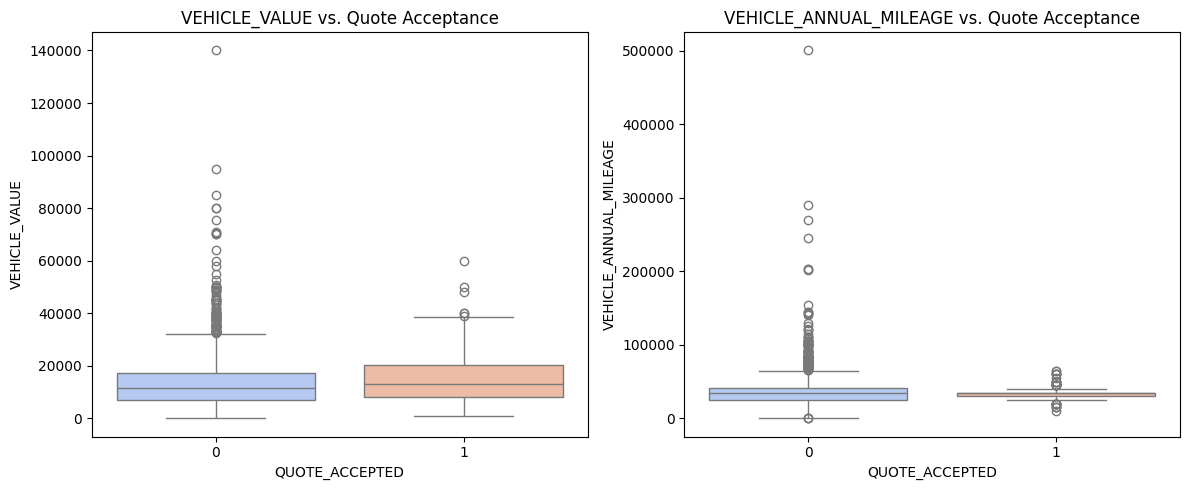

In [21]:
plt.figure(figsize=(12, 5))

vehicle_features = ["VEHICLE_VALUE", "VEHICLE_ANNUAL_MILEAGE"]

for i, feature in enumerate(vehicle_features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df["QUOTE_ACCEPTED"], y=df[feature], palette="coolwarm")
    plt.title(f"{feature} vs. Quote Acceptance")

plt.tight_layout()
plt.show()

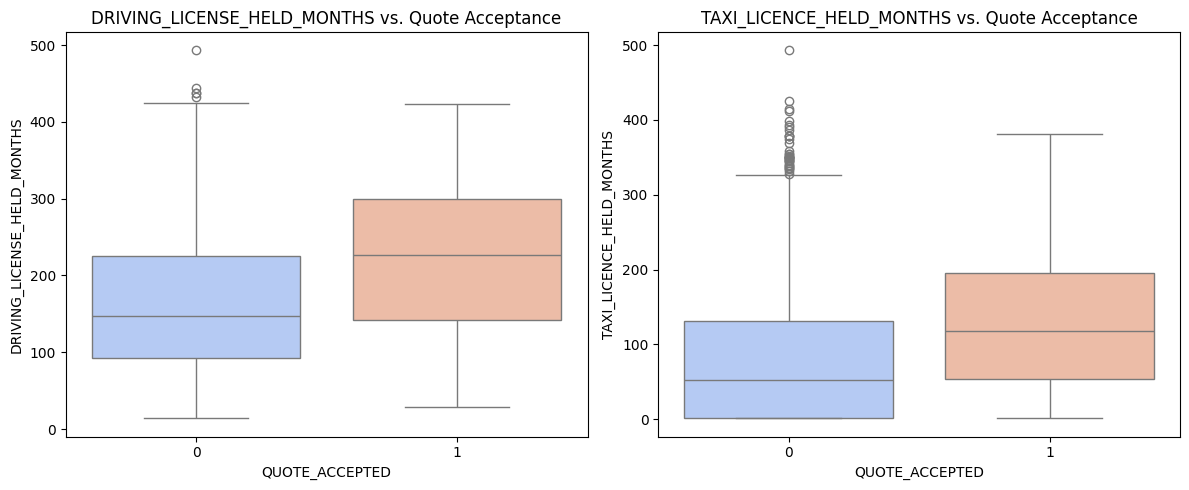

In [22]:
plt.figure(figsize=(12, 5))

experience_features = ["DRIVING_LICENSE_HELD_MONTHS", "TAXI_LICENCE_HELD_MONTHS"]

for i, feature in enumerate(experience_features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=df["QUOTE_ACCEPTED"], y=df[feature], palette="coolwarm")
    plt.title(f"{feature} vs. Quote Acceptance")

plt.tight_layout()
plt.show()

In [23]:
df.drop(columns=["QUOTE_STATUS", "CREATED_AT"], inplace=True)

target = "QUOTE_ACCEPTED"

df_features = df[df.columns.difference([target])]
df_target = df[target]

## Feature selection + engineering

In [24]:
def categorize_variables(target, df, cat_numeric_unique_threshold=10):
    categorical_numeric = [
        var
        for var in df.columns
        if df[var].dtype != "O" and var != target and df[var].nunique() <= cat_numeric_unique_threshold
    ]
    continuous = [
        var for var in df.columns if df[var].dtype != "O" and var != target and var not in categorical_numeric
    ]
    mixed = [var for var in df.columns if var != target and pd.api.types.infer_dtype(df[var]) == "mixed"]
    categorical_object = [var for var in df.columns if var != target and df[var].dtype == "O" and var not in mixed]
    sorted_features = [target, *categorical_numeric, *continuous, *categorical_object, *mixed]
    print("Total columns: " + str(df.columns.size) + "\nColumns after sorting: " + str(len(sorted_features)))
    return categorical_numeric, continuous, mixed, categorical_object


categorical_numeric, continuous, mixed, categorical_object = categorize_variables(target, df)

Total columns: 28
Columns after sorting: 28


### Univariate feature selection

In [25]:
sel_constant = DropConstantFeatures(tol=0.998, variables=None, missing_values="raise")
sel_constant.fit(df_features)
constant_to_drop = sel_constant.features_to_drop_
constant_to_drop

[]

In [26]:
sel_duplicate = DropDuplicateFeatures(variables=None, missing_values="raise")
sel_duplicate.fit(df_features)
duplicate_to_drop = sel_duplicate.features_to_drop_
duplicate_to_drop

set()

As we can see there are no constant or duplicate features.

### Multivariate feature selection

In [27]:
# TODO cross feature correlation?

Now let's see which features are most correlated to target using boruta algorithm.

### Feature engineering 

Let's transform date into multiple columns.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    df_features, df_target, test_size=0.3, random_state=0, stratify=df_target
)

One Hot Encode categorical variables

In [29]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Encode categorical features
x_train_encoded = pd.DataFrame(
    encoder.fit_transform(x_train[categorical_object]),
    columns=encoder.get_feature_names_out(categorical_object),
    index=x_train.index,
)

x_test_encoded = pd.DataFrame(
    encoder.transform(x_test[categorical_object]),
    columns=encoder.get_feature_names_out(categorical_object),
    index=x_test.index,
)

# Combine encoded and numerical features
x_train = pd.concat([x_train.drop(columns=categorical_object), x_train_encoded], axis=1)
x_test = pd.concat([x_test.drop(columns=categorical_object), x_test_encoded], axis=1)

### Target correlation feature selection

In [30]:
x_train_boruta = x_train.copy()

rf_boruta = RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    max_depth=10,
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=1,
)

boruta_selector = BorutaPy(rf_boruta, n_estimators="auto", verbose=0, random_state=1)

boruta_selector.fit(x_train_boruta.values, y_train)

selected_features = x_train_boruta.columns[boruta_selector.support_].tolist()

pd.DataFrame({"Feature": x_train_boruta.columns, "Ranking": boruta_selector.ranking_}).sort_values(by="Ranking")


,Feature,Ranking
0,ADDRESS_LATITUDE,1
1,ADDRESS_LONGITUDE,1
6,CREATED_AT_hour,1
5,BROKER_ID,1
14,DRIVING_LICENSE_HELD_MONTHS,1
22,VEHICLE_VALUE,1
19,TAXI_LICENCE_HELD_MONTHS,1
17,NO_CLAIMS_BONUS_YEARS,1
21,VEHICLE_ANNUAL_MILEAGE,1
28,QUOTE_TYPE_Renewal,1


In [31]:
relevant_features = [
    "ADDRESS_LATITUDE",
    "ADDRESS_LONGITUDE",
    "CREATED_AT_hour",
    "BROKER_ID",
    "DRIVING_LICENSE_HELD_MONTHS",
    "VEHICLE_VALUE",
    "TAXI_LICENCE_HELD_MONTHS",
    "NO_CLAIMS_BONUS_YEARS",
    "VEHICLE_ANNUAL_MILEAGE",
    "QUOTE_TYPE_Renewal",
    "QUOTE_TYPE_New Business",
]

x_train = x_train[relevant_features]
x_test = x_test[relevant_features]

## Metric, model selection and hyperparameters search

### Metric selection

As our metric it is reasonable to choose f1 score of `precision` and `recall`.<br>
Precision so that we don't concentrate resources on quotes that are less likely to convert into sales. By focusing on precision, we ensure that when a quote is identified as having a high likelihood of conversion, the prediction is accurate, minimizing wasted efforts on less promising leads. This approach helps to allocate marketing and engagement resources more efficiently, optimizing the time and cost involved in converting a quote to a sale.

Recall is equally important as it ensures that we do not miss out on potential sales by failing to identify quotes that could convert. A high recall rate means that our model successfully captures a large proportion of all actual conversions. This is crucial for maximizing the opportunity to increase overall sales, as failing to identify and engage with these opportunities would result in missed revenue.

`ROC-AUC` can be an auxiliary metric as it quantifies how effectively our model differentiates between successful and unsuccessful insurance quotes, enabling us to fine-tune our engagement strategies to focus precisely on the most promising leads.

### SMOTE

As we have chosen our most relevant features, now we can verify if addressing target imbalance with SMOTE technique helps to improve our metrics.

In [32]:
def train_and_evaluate(x_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    precision = cross_val_score(model, x_train, y_train, cv=cv, scoring="precision", n_jobs=-1).mean()
    recall = cross_val_score(model, x_train, y_train, cv=cv, scoring="recall", n_jobs=-1).mean()
    f1 = cross_val_score(model, x_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
    roc_auc = cross_val_score(model, x_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

    metrics = {"Precision": precision, "Recall": recall, "F1-score": f1, "ROC-AUC": roc_auc}

    return metrics

baseline_metrics = train_and_evaluate(x_train, y_train)

smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

smote_metrics = train_and_evaluate(x_train_smote, y_train_smote)

pd.DataFrame([baseline_metrics, smote_metrics], index=["No SMOTE", "With SMOTE"])

,Precision,Recall,F1-score,ROC-AUC
No SMOTE,0.601199,0.165722,0.257333,0.825897
With SMOTE,0.935872,0.953043,0.944244,0.985470


We can clearly see that all scores are significantly higher if we balance our dataset, so we can apply it to our training data.

In [33]:
x_train, y_train = smote.fit_resample(x_train, y_train)

In [34]:
def combined_metric(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return f1, roc_auc

N_JOBS = multiprocessing.cpu_count()

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["logit", "RF", "GBM", "XGB"])

    if classifier_name == "logit":
        logit_penalty = trial.suggest_categorical("logit_penalty", ["l1", "l2"])
        logit_c = trial.suggest_float("logit_c", 0.001, 10)
        model = LogisticRegression(penalty=logit_penalty, C=logit_c, solver="saga", max_iter=1000)

    elif classifier_name == "RF":
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        rf_criterion = trial.suggest_categorical("rf_criterion", ["gini", "entropy"])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 10)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)
        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
        )

    elif classifier_name == "GBM":
        gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 100, 1000)
        gbm_criterion = trial.suggest_categorical("gbm_criterion", ["friedman_mse"])
        gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 10)
        gbm_min_samples_split = trial.suggest_float("gbm_min_samples_split", 0.01, 1)
        model = GradientBoostingClassifier(
            n_estimators=gbm_n_estimators,
            criterion=gbm_criterion,
            max_depth=gbm_max_depth,
            min_samples_split=gbm_min_samples_split,
        )

    elif classifier_name == "XGB":
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 1000)
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.1)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 3, 8)
        xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 3, 8)
        xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 0.9)
        xgb_reg_lambda = trial.suggest_float("xgb_reg_lambda", 0.01, 10.0)
        xgb_reg_alpha = trial.suggest_float("xgb_reg_alpha", 0.1, 5.0)

        model = XGBClassifier(
            n_estimators=xgb_n_estimators,
            learning_rate=xgb_learning_rate,
            max_depth=xgb_max_depth,
            min_child_weight=xgb_min_child_weight,
            colsample_bytree=xgb_colsample_bytree,
            reg_lambda=xgb_reg_lambda,
            reg_alpha=xgb_reg_alpha,
            tree_method="gpu_hist",
            gpu_id=0
        )


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred = cross_val_predict(model, x_train, y_train, cv=cv, method="predict")

    f1, roc_auc = combined_metric(y_train, y_pred)

    return f1, roc_auc

def best_params_model(best_trial):
    best_params = best_trial.params
    classifier = best_params.pop("classifier", None)
    clean_params = {key.split("_", 1)[-1]: value for key, value in best_params.items()}

    model_mapping = {
        "logit": LogisticRegression,
        "GBM": GradientBoostingClassifier,
        "XGB": XGBClassifier,
        "RF": RandomForestClassifier,
    }

    model_class = model_mapping.get(classifier, None)

    if model_class is None:
        raise ValueError(f"Unknown classifier type: {classifier}")

    model = model_class(**clean_params)

    start_mlflow_server()
    mlflow.set_experiment('taxi-insurance-quotes')
    with mlflow.start_run():
        mlflow.log_params(clean_params)
        mlflow.sklearn.log_model(model, "best_model")
        mlflow.log_metric("F1-score", best_trial.values[0])
        mlflow.log_metric("ROC-AUC", best_trial.values[1])
        print(f"Model {classifier} with best parameters logged to MLflow.")

    return model

study = optuna.create_study(directions=["maximize","maximize"])
study.optimize(objective, n_trials=1, n_jobs=N_JOBS)

best_trial = sorted(study.best_trials, key=lambda t: t.values[0], reverse=True)[0]

best_model = best_params_model(best_trial)

display(f"Best study params: {best_trial.params}")
display(f"Best study metric value: {best_trial.values}")

[I 2025-02-12 12:09:55,139] A new study created in memory with name: no-name-d4b1d383-d3ab-4fd3-ade8-4d9b63531cee
[I 2025-02-12 12:10:01,808] Trial 0 finished with values: [0.9276353276353276, 0.9263768115942029] and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 343, 'gbm_criterion': 'friedman_mse', 'gbm_max_depth': 3, 'gbm_min_samples_split': 0.016818128663844332}.
2025/02/12 12:10:02 INFO mlflow.tracking.fluent: Experiment with name 'taxi-insurance-quotes' does not exist. Creating a new experiment.


MLflow server is already running on port 8080


2025/02/12 12:10:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/02/12 12:10:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model GBM with best parameters logged to MLflow.
🏃 View run resilient-skunk-551 at: http://127.0.0.1:8080/#/experiments/769483749542577315/runs/d874b021d48c4365863e336874384b32
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/769483749542577315


"Best study params: {'gbm_n_estimators': 343, 'gbm_criterion': 'friedman_mse', 'gbm_max_depth': 3, 'gbm_min_samples_split': 0.016818128663844332}"

'Best study metric value: [0.9276353276353276, 0.9263768115942029]'

In [35]:
best_model.fit(x_train, y_train)

y_test_pred = best_model.predict(x_test)
y_test_pred_proba = best_model.predict_proba(x_test)[:, 1]

classification_rep = classification_report(y_test, y_test_pred)
f1, roc_auc = combined_metric(y_test, y_test_pred)

print(f"ROC-AUC score: {roc_auc}")
print(f"F1 score: {f1}")
print(classification_rep)

ROC-AUC score: 0.7481212920237311
F1 score: 0.46296296296296297
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       740
           1       0.37      0.61      0.46        82

    accuracy                           0.86       822
   macro avg       0.66      0.75      0.69       822
weighted avg       0.90      0.86      0.87       822



In [37]:
import joblib
import os


os.makedirs("app/target", exist_ok=True)
filepath = os.path.join("app/target", "model.pkl")
joblib.dump(best_model, filepath)
print(f"Model saved as {filepath}")


Model saved as app/target\model.pkl
